In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import os

Analysis of sp500 from 1927 to 2023

In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
sp500.index = pd.to_datetime(sp500.index)

In [5]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-23 00:00:00-04:00,4354.169922,4366.549805,4341.339844,4348.330078,6053620000,0.0,0.0
2023-06-26 00:00:00-04:00,4344.839844,4362.060059,4328.080078,4328.819824,3415030000,0.0,0.0
2023-06-27 00:00:00-04:00,4337.359863,4384.419922,4335.000000,4378.410156,3573500000,0.0,0.0


<AxesSubplot:xlabel='Date'>

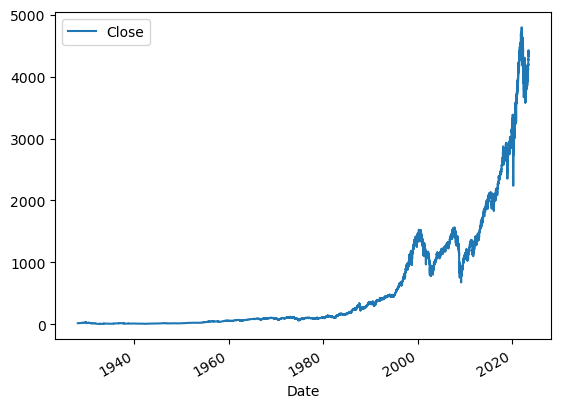

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()


In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [10]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.59375

<AxesSubplot:xlabel='Date'>

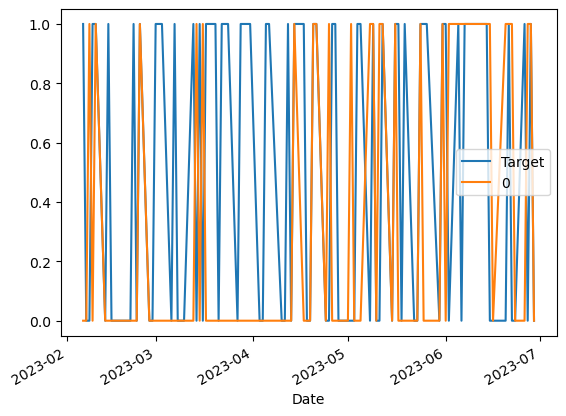

In [26]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [12]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [13]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
predictions = backtest(sp500, model, predictors)

In [15]:
predictions["Predictions"].value_counts()

0    3434
1    2504
Name: Predictions, dtype: int64

In [16]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5295527156549521

In [17]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.53385
0    0.46615
Name: Target, dtype: float64

In [18]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [19]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [20]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [21]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [22]:
predictions = backtest(sp500, model, new_predictors)

In [23]:
predictions["Predictions"].value_counts()

0.0    4122
1.0     816
Name: Predictions, dtype: int64

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5686274509803921

In [25]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.543742
0    0.456258
Name: Target, dtype: float64